In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
data=pd.read_csv("../input/train.csv")
data_pred=pd.read_csv("../input/test.csv")

In [3]:
data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [4]:
data_pred.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

In [5]:
#data.info(verbose=True, null_counts=True)

In [6]:
#data_pred.info(verbose=True, null_counts=True)

No Null data or empty data in woth data sets

In [7]:
data['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

The Target is a dichotomic variable with the following histogram distribution. 

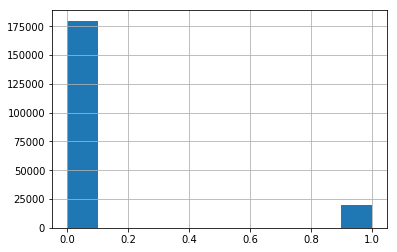

In [8]:
data['target'].hist()

My first conclusion is that we have a data set with 200 variables and a dichotomic target variable.
The set is labeled therefore we are facing a case of supervised classification.

# EDA

In [9]:
import matplotlib.pyplot as plt

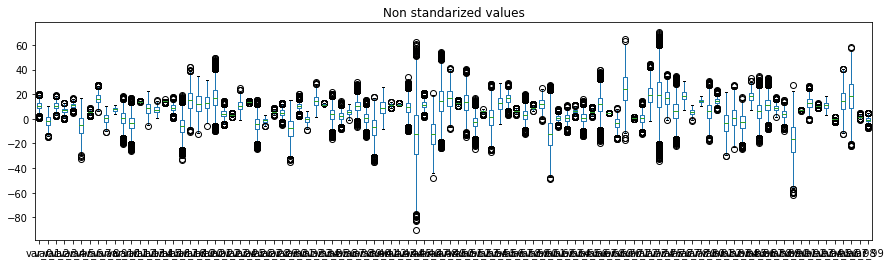

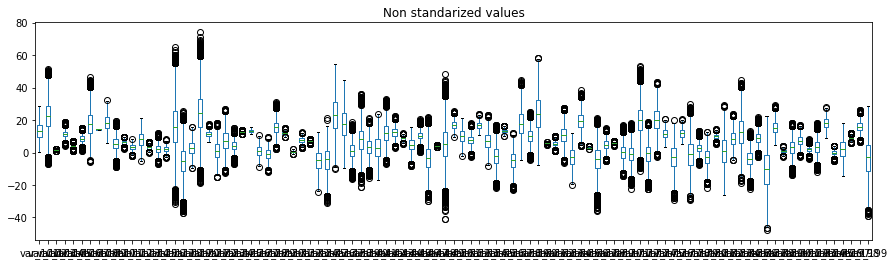

In [10]:
data[data.columns[2:102]].plot(kind='box', figsize=[15,4], title='Non standarized values')
data[data.columns[103:]].plot(kind='box', figsize=[15,4], title='Non standarized values')


In [11]:
import seaborn as sns

An alternative to the bar histogram could be the density graph, that will allow us to compare the values distribution of the different variables. In our density plot graph, a variable presents a distribution far away from normality.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'density')

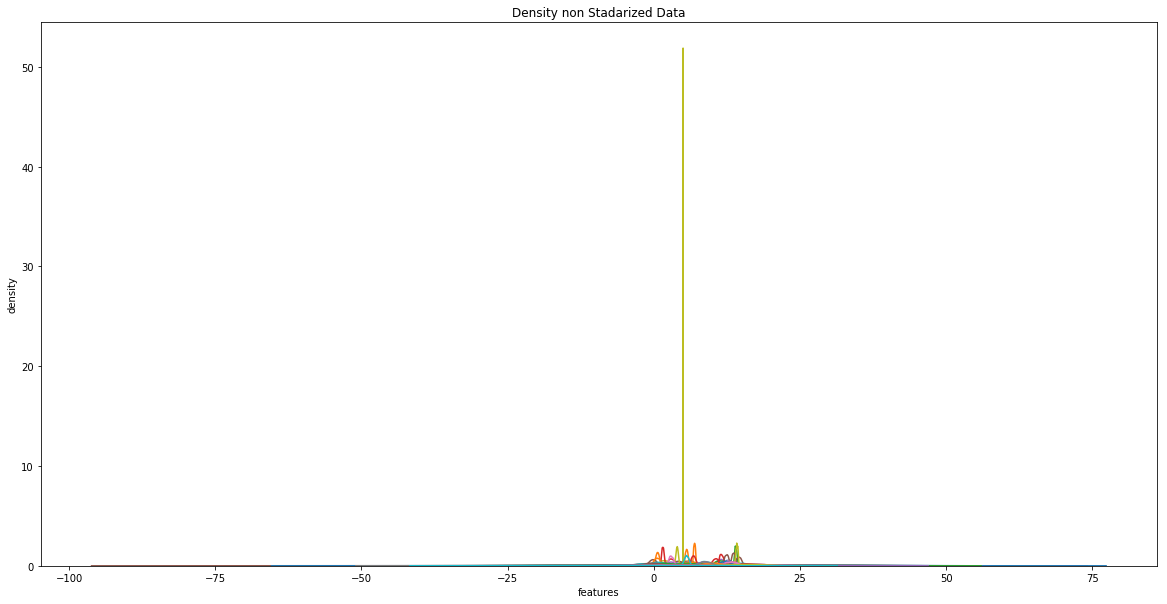

In [12]:
values=data.columns.drop(['ID_code', 'target'])
plt.figure(figsize=(20,10))
for val in values:
    sns.distplot(data[val], hist=False)
plt.title('Density non Stadarized Data')
plt.xlabel('features')
plt.ylabel('density')

In [13]:
datamax=pd.DataFrame(data=data.max(),columns=['max'])

In [14]:
print (datamax.max())

Series([], dtype: float64)


## **Multicorrelation Analytic**

In [15]:
features=data.drop(columns=['ID_code', 'target'])
correlations = data.corr().unstack().sort_values(ascending=True)
cor_abs=correlations.abs().reset_index()

I have to remove from corr_abs those values pairs wich are equals, this twins pairs values does not offers any information their correlation is obviously 1

In [16]:
cor_abs=cor_abs[cor_abs['level_0']!=cor_abs['level_1']]
cor_abs=cor_abs.set_axis(['level_0', 'level_1', 'cor'],axis=1, inplace=False)

In [17]:
cor_abs.tail(10)

,level_0,level_1,cor
40190,var_22,target,0.060558
40191,target,var_22,0.060558
40192,var_26,target,0.062422
40193,target,var_26,0.062422
40194,var_53,target,0.063399
40195,target,var_53,0.063399
40196,target,var_110,0.064275
40197,var_110,target,0.064275
40198,var_6,target,0.066731
40199,target,var_6,0.066731


The more correlated pairs of values does not approach to 1, they show a relatively low correlation, therefore 'features' does not have a big multicorrelation

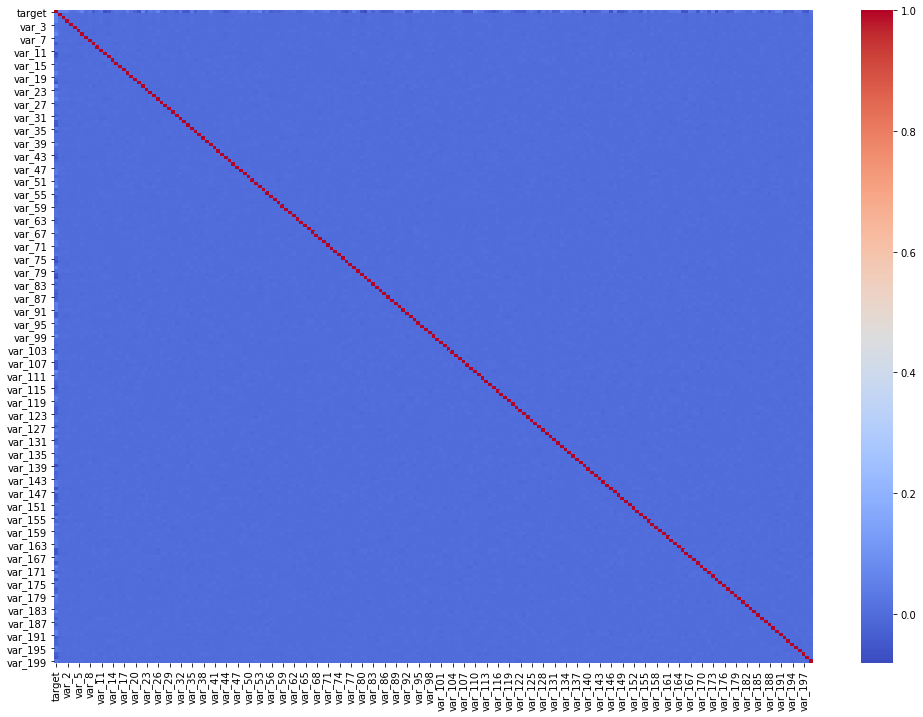

In [19]:
corr=data.corr()
plt.figure(figsize=(17,12))
sns.heatmap(corr, cmap='coolwarm')

# Splitting Train and Test Sets

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train, test=train_test_split(data, test_size=0.25)
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
34026,train_34026,0,10.6331,3.6762,11.0666,8.6654,10.1350,-0.3478,6.6802,16.3551,1.6827,6.8766,6.4752,-11.1486,14.0901,-2.2728,10.1413,14.4269,12.9000,-1.1155,28.1031,9.0329,7.6731,18.4956,3.9306,3.9862,14.7108,13.9343,-0.1464,-3.8102,5.0934,4.8271,-12.7884,9.8602,0.7059,16.6113,10.7333,2.1999,-1.0452,7.6890,...,9.5344,5.6921,7.3166,12.8621,2.4039,19.3169,2.9904,-3.8566,1.8320,5.5673,-8.0648,2.3639,19.4478,-6.7645,27.9607,12.4334,2.2076,8.0886,8.8211,2.2032,-2.9681,11.5464,-2.3319,12.8681,12.3025,-7.8276,14.4873,-10.9256,15.2945,2.2372,-1.3984,2.9899,4.0758,4.0960,21.7318,0.3935,10.7383,8.0827,18.7000,4.0877
22711,train_22711,0,8.9280,3.0905,8.2015,4.0542,12.3817,-15.0160,4.2993,15.0926,-4.0402,6.1668,-7.9824,-5.1355,14.4295,13.0408,5.7741,14.4714,6.7546,-2.6329,17.8566,15.2301,16.4151,21.0489,8.8296,3.8155,13.0907,14.0973,-4.2097,0.1068,4.7534,0.5928,-17.3034,9.7535,0.9218,19.7910,11.8835,1.3639,8.1339,5.0352,...,21.2383,5.7310,4.9326,4.6994,-10.0959,18.9732,2.9183,-4.5449,9.2815,6.1137,4.2560,11.1906,29.1760,5.3981,14.2258,13.1948,-13.9237,13.2860,13.3066,1.0632,0.1082,11.5540,3.1729,12.8769,22.2033,-5.3002,13.0313,-1.1101,9.7426,0.1698,2.8228,7.7704,2.3807,1.4713,23.4361,-2.1428,-0.3861,8.2156,14.4250,-9.5482
130235,train_130235,0,12.0830,-1.7309,11.3017,4.8743,12.1113,-21.2662,4.8491,11.7256,2.8806,7.2971,2.4939,-14.2585,14.0274,6.3648,8.3859,14.0874,9.3825,-3.5906,20.2529,21.9402,13.5389,32.8827,7.0733,1.9435,9.7235,13.5887,-16.4102,-0.6594,6.4059,8.5603,3.4446,10.6429,1.7307,19.6354,11.1445,-7.5477,0.6124,10.2177,...,29.8033,5.6609,4.2810,9.9930,-4.9251,18.8566,2.8194,-2.5841,4.3399,5.5550,-8.4529,-1.0707,14.6487,1.3413,21.4550,12.3087,1.0846,14.5404,2.4468,0.2771,3.1612,9.7966,6.0701,5.0145,24.7992,-10.2212,9.9428,-3.6083,12.7675,2.2350,3.3239,5.3563,0.9337,-0.3999,13.6690,-0.4415,4.7626,9.2848,12.9407,4.6860
50427,train_50427,0,8.4078,4.0993,13.2079,7.6046,11.7401,-8.1131,4.7926,16.2932,3.8778,7.7425,-1.1743,-0.3758,14.0945,11.5776,7.2455,14.9996,10.5905,-8.9856,9.5670,-1.2974,18.0355,17.8432,2.3287,3.5319,6.1845,13.3462,8.1848,-2.4394,6.4454,5.4820,-16.6045,12.2601,-1.0552,12.1521,10.1251,8.3345,-3.3897,7.7280,...,23.6961,5.4815,5.3559,8.6481,0.8511,15.5418,2.9972,-4.6107,7.6051,4.9096,-3.6352,-5.4280,21.6344,-4.5926,15.6368,12.7722,-7.7591,10.6130,2.0417,2.6412,9.0166,11.8070,-11.5666,14.6581,7.7758,-8.7266,16.5259,-6.1067,10.4887,-1.4418,-2.1949,9.2285,1.8030,0.7441,22.2057,1.1482,4.7632,8.9892,12.4016,1.5548
163025,train_163025,0,10.8592,4.0484,12.1465,6.9454,8.2065,2.5911,5.6060,8.9891,-1.6810,7.4038,1.4339,-2.4796,14.1703,13.7920,11.6339,14.4234,10.3579,-11.2320,17.3029,17.1846,-0.0973,17.8417,9.6972,2.3745,18.8769,13.4943,-11.6298,-3.1898,6.0514,5.5664,-7.8329,9.1665,-2.1225,14.6593,11.0970,12.4087,5.1187,6.6436,...,5.6441,5.5780,4.4045,13.8688,-1.7236,27.1345,2.4498,-9.2814,10.0069,5.3343,-0.9308,-3.6143,9.1439,-2.7017,23.9082,8.7689,-4.4629,14.5323,-5.2639,2.6315,-11.7170,9.3965,-4.7451,12.4814,10.6878,2.1126,7.5704,8.3901,17.8617,1.2822,-0.9529,4.5628,5.1398,3.5925,18.5769,-1.3074,8.9291,9.1339,19.9835,-14.6015


In [22]:
x=train[train.columns[2:202]]
y_train=train[train.columns[1:2]]


In [23]:
xt=test[test.columns[2:202]]
y_test=test[test.columns[1:2]]

# Features Selection

In [26]:
x_arr=np.asarray(x)
y_arr=np.asarray(y_train['target'])
features=x.columns
y_arr

array([0, 0, 0, ..., 1, 0, 0])

In [27]:

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=4)
feature_selector = sfs(estimator=knn,  
           k_features=(50,200),
           forward=True,
           verbose=2,
           scoring='accuracy',
           cv=4)

In [ ]:
feature_selector.fit(x_arr, y_arr, custom_feature_names=features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished

[2019-03-25 10:11:39] Features: 1/200 -- score: 0.896686659659866[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 199 out of 199 | elapsed:  2.5min finished

[2019-03-25 10:14:10] Features: 2/200 -- score: 0.896473332726381[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:  2.9min finished

[2019-03-25 10:17:01] Features: 3/200 -- score: 0.8967733396599276[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

# **Data Standarization**

First I will split my data set into train and test

In [ ]:
from sklearn import preprocessing
std=preprocessing.StandardScaler()

In [ ]:
x_names=x.columns

In [ ]:
x_tr=std.fit_transform(x)
x_train=pd.DataFrame(x_tr, columns=x_names)

In [ ]:
xts=std.fit_transform(xt)
x_test=pd.DataFrame(xts, columns=x_names)

## ** EDA Data Standarized vs Non Standarized**

In [ ]:
data[data.columns[2:102]].plot(kind='box', figsize=[15,4], title='Non standarized values')
x_train[x_train.columns[:100]].plot(kind='box', figsize=[15,4], title='Standarized values')
data[data.columns[103:]].plot(kind='box', figsize=[15,4], title='Non standarized values')
x_train[x_train.columns[101:]].plot(kind='box', figsize=[15,4], title='Standarized values')

In [ ]:
values=data.columns.drop(['ID_code', 'target'])
plt.figure(figsize=(20,10))
for val in values:
    sns.distplot(data[val], hist=False)
plt.title('Density non Stadarized Data')
plt.xlabel('features')
plt.ylabel('density')

plt.figure(figsize=(20,10))
for val in values:
    sns.distplot(x_train[val], hist=False)
plt.title('Density Stadarized Data')
plt.xlabel('features')
plt.ylabel('density')


I will try a 5 layer dense neuronal net model using Keras
As a frst step I will train the model with non normalized data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as k
from tensorflow.keras.models import model_from_json




In [ ]:

xtot_non=train[train.columns[2:202]]
features=xtot_non.shape[1]
data=xtot_non.as_matrix()
lab=y_train.as_matrix()
label=to_categorical(lab)
data_test=xt.as_matrix()
lab_test=y_test.as_matrix()
label_test=to_categorical(lab_test)



In [ ]:
model=tf.keras.Sequential()
k.clear_session()

model.add(layers.Dense(400, activation='relu', input_shape=(features,)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(data, label, epochs=25, batch_size=512)

In [ ]:
model.evaluate(data_test, label_test, batch_size=512)